In [4]:
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt

from mne.time_frequency import tfr_array_morlet

In [29]:
def get_frequencies():
    return np.array(
        [2.        ,   2.26576777,   2.5668518 ,   2.90794503,
            3.29436407,   3.73213197,   4.22807216,   4.78991482,
            5.42641731,   6.14750073,   6.96440451,   7.88986164,
            8.9382971 ,  10.12605275,  11.47164198,  12.99603834,
            14.72300241,  16.67945217,  18.89588258,  21.40684088,
            24.25146506,  27.47409397,  31.12495832,  35.26096371,
            39.94657756,  45.254834  ,  51.26847217,  58.08122594,
            65.79928491,  74.54294953,  84.44850629,  95.67035191,
            110.        , 130.        , 150.        , 170.        ,
            190.        , 210.        , 230.        , 250.        ,
            270.        , 290.        , 310.        , 330.        ,
            350.        , 370.        , 390.        , 410.        ,
            430.        , 450.        ])

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)
fs = 5000

1. simulate real signals with white noise and a single-band "real" oscillation at 100, 200, 300, 400, and 500 Hz so that the signal is generated at 5 kHz

In [30]:
frequencies = get_frequencies()

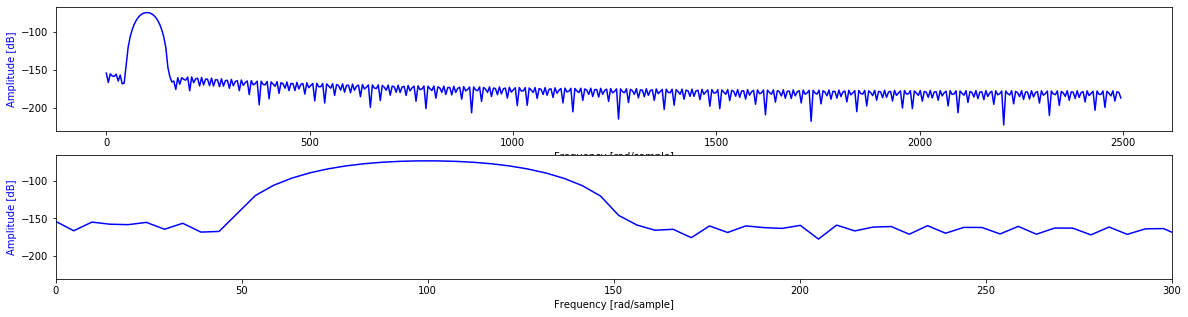

In [6]:
def design_fir_filter(f, fs=5000, numtaps=401):
    
    f_cut1, f_cut2 = ((f-20)/(fs/2), (f+20)/(fs/2))

    b = signal.firwin(numtaps, [f_cut1, f_cut2], window=('kaiser', 8), pass_zero=False)

    w, h = signal.freqz(b, fs)

    return b, w, h

def morlet_filter(f_central, fs=5000):
    x = tfr_array_morlet(data[np.newaxis,...], fs, [f_central],7.5, output='complex')
    return x

def filter_data(data, f_central, fs):
    return tfr_array_morlet(data[np.newaxis,np.newaxis,...], fs, [f_central],7.5, output='complex').squeeze()

T = 1/fs
t = np.arange(0,5,T)
noise = np.random.normal(0,1,*t.shape)

b, w, h = design_fir_filter(100)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))

freq = w * fs / (2*np.pi)

ax1.plot(freq, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]');

ax2.plot(freq, 20 * np.log10(abs(h)), 'b')
ax2.set_ylabel('Amplitude [dB]', color='b')
ax2.set_xlabel('Frequency [rad/sample]');
ax2.set_xlim([0,300]);

2. the real oscillation can be generated by filtering white noise at these frequencies and then just sum it to the baseline white noise in (1) with some weight (= SNR)

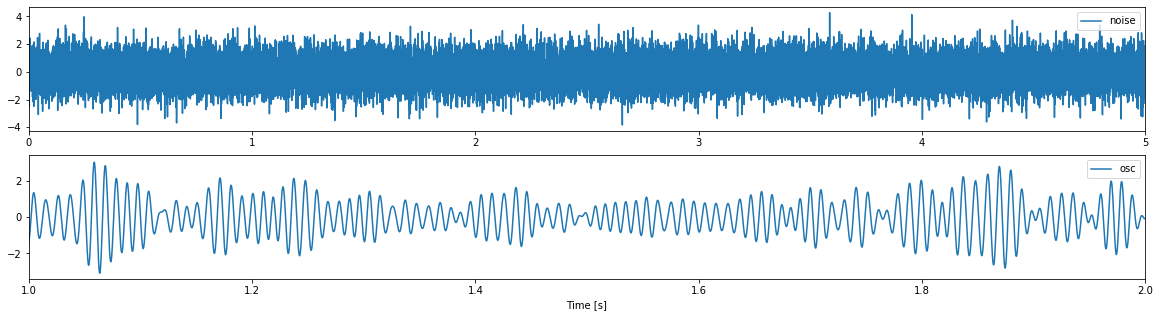

In [7]:
def simulate_osc(f_central, noise):
    b, _, _ = design_fir_filter(f_central)
    x1 = signal.filtfilt(b, [1.0], noise)
    return x1

def simulate_osc_mor(f_central, noise, real=False, fs=5000 ):
    x = filter_data(noise, f_central,fs)
    if real:
        x = np.real(x)
    return x

def compute_phase_corr(x1, x2):
    return np.abs(np.mean(np.exp(1j*(np.angle(x1)-np.angle(x2)))))


x1 = simulate_osc_mor(100, noise)
X = np.real(x1) + noise
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, noise, label='noise')
ax1.set_xlim([0,5]);
ax2.plot(t, np.real(x1), label='osc')
ax2.set_xlim([1,2]);
ax2.set_xlabel('Time [s]')

ax1.legend()
ax2.legend();

1. ground truth oscillation & spectrum
2. oscillation with noise & spectrum
3. oscillation with noise+linenoise & spectrum with and without notches

3. then filter the signal generated this way with our current bank of filters and plot the signal amplitude as a function of frequency

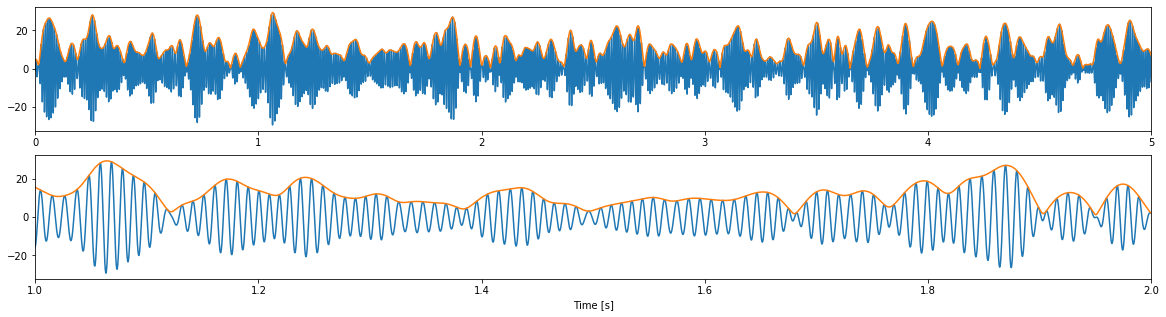

In [8]:
x_fir = filter_data(X, 100, fs)
ampl = np.abs(x_fir)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, np.real(x_fir))
ax1.plot(t, ampl)
ax1.set_xlim([0,5])

ax2.plot(t, np.real(x_fir))
ax2.plot(t, ampl)
ax2.set_xlim([1,2])
ax2.set_xlabel('Time [s]');

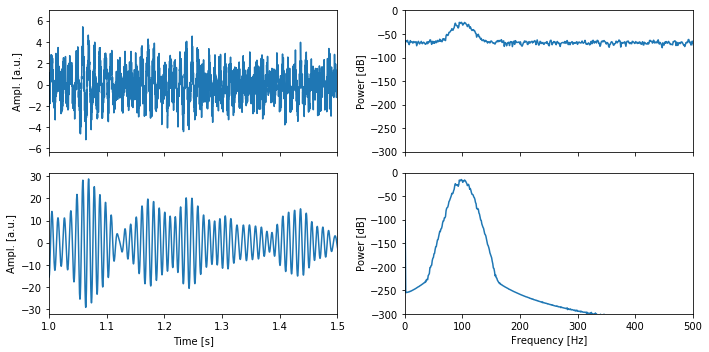

In [24]:
fig, axs = plt.subplots(2,2,figsize=(10,5), sharex='col')

f, orig_Pxx = signal.welch(X, fs, nfft=5000, nperseg=5000)
_, filt_Pxx = signal.welch(np.real(x_fir), fs, nfft=5000, nperseg=5000)

axs[0][0].plot(t, np.real(X))
axs[0][0].set_xlim([1,1.5])
axs[0][1].plot(f, 20*np.log10(orig_Pxx))
axs[0][1].set_xlim([0,500])
axs[0][1].set_ylim([-300, 0])
axs[1][0].plot(t, np.real(x_fir))
axs[1][1].plot(f, 20*np.log10(filt_Pxx)-30)
axs[1][1].set_xlim([0,500])
axs[1][1].set_ylim([-300, 0])

axs[0][0].set_ylabel('Ampl. [a.u.]')
axs[1][0].set_ylabel('Ampl. [a.u.]')

axs[0][1].set_ylabel('Power [dB]')
axs[1][1].set_ylabel('Power [dB]')

axs[1][0].set_xlabel('Time [s]')
axs[1][1].set_xlabel('Frequency [Hz]')
fig.tight_layout()
fig.savefig('/home/gabri/nyquist_panela.svg', dpi=300)

In [134]:
def z_score(arr):
    return (arr - arr.mean(axis=1, keepdims=True))/arr.std(axis=1, keepdims=True)


n_freqs_x = 30

ampl_spectrum = np.zeros((2,4,n_freqs_x))

for idx, f_c in enumerate(np.arange(100,500,100)):
    # 1. gen signal
    x1 = simulate_osc_mor(f_c, noise, real=True, fs=5000)
    X = x1 + noise

    for jdx, f in enumerate(frequencies[-n_freqs_x:]): 
        
        x_filt = filter_data(X, f, 5000)
        ampl = np.abs(x_filt)
        #ampl = z_score(ampl)
        ampl_spectrum[0, idx, jdx] = np.mean(ampl) 

In [135]:
for idx, f_c in enumerate(np.arange(100,500,100)):
    # 1. gen signal
    x1 = simulate_osc_mor(f_c, noise, real=True, fs=1000)
    X = x1 + noise

    for jdx, f in enumerate(frequencies[-n_freqs_x:]): 
        
        x_filt = filter_data(X, f, 1000)
        ampl = np.abs(x_filt)
        #ampl = z_score(ampl)
        ampl_spectrum[1, idx, jdx] = np.mean(ampl)                                 

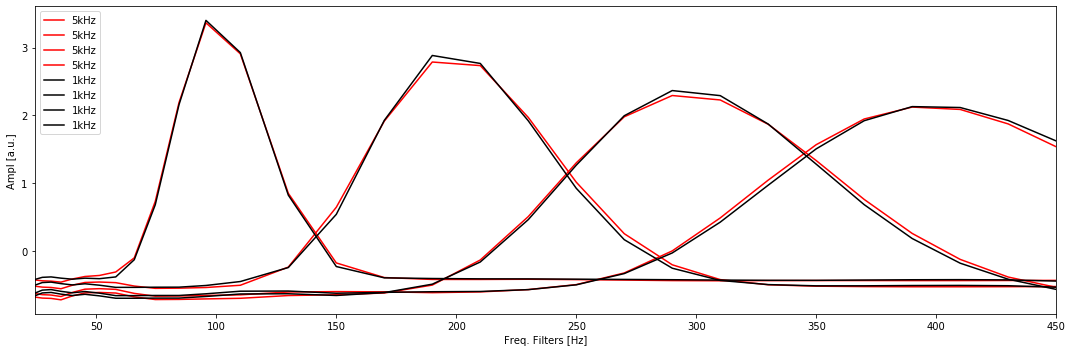

In [138]:
        
fig = plt.figure(figsize=(15,5))

plt.plot(frequencies[-n_freqs_x:], z_score(ampl_spectrum[0]).T, color='r', label='5kHz')
plt.plot(frequencies[-n_freqs_x:], z_score(ampl_spectrum[1]).T, 'k', label='1kHz')


plt.ylabel('Ampl [a.u.]')
plt.xlabel('Freq. Filters [Hz]')
plt.xlim([frequencies[-n_freqs_x:].min(), frequencies[-n_freqs_x:].max()])
plt.legend()


fig.tight_layout()
fig.savefig('/home/gabri/nyquist_panelc_1.svg', dpi=300)

In [74]:
ampl_spectrum.shape

(2, 4, 30)

4. for the peak (100 Hz for the simulated real 100 Hz signal etc), compute the phase correlation of the filter-recovered signal and original signal generated in (2)

PLV: 0.9437403571424363


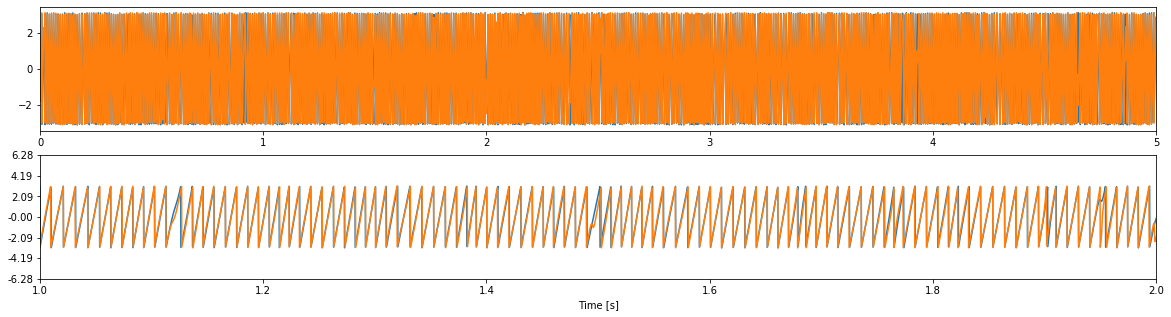

In [156]:
f = 100
x1 = simulate_osc_mor(f, noise)
X = np.real(x1) + noise
x_filt = filter_data(X, f, fs)

phase_corr = compute_phase_corr(x_filt, x1)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, np.angle(x_filt))
ax1.plot(t, np.angle(x1))
ax1.set_xlim([0,5])

ax2.plot(t, np.angle(x_filt))
ax2.plot(t, np.angle(x1))
ax2.set_xlim([1,2])
ax2.set_ylim([-2*np.pi, 2*np.pi])
ax2.set_yticks(np.arange(-2*np.pi, (2*np.pi)+1, (4*np.pi)/6))
ax2.set_yticklabels(['%.2f'%x for x in np.arange(-2*np.pi, (2*np.pi)+1, (4*np.pi)/6)])
ax2.set_xlabel('Time [s]')

print('PLV:', phase_corr)
fig.savefig('/home/gabri/nyquist_panelb.svg', dpi=300)

In [153]:
np.arange(-2*np.pi, (2*np.pi)+1, (4*np.pi)/6)

array([-6.28318531e+00, -4.18879020e+00, -2.09439510e+00, -1.77635684e-15,
        2.09439510e+00,  4.18879020e+00,  6.28318531e+00])

5. plot the phase correlation for all five frequencies 100, ..., 500

Text(0.5, 0, 'Freq. [Hz]')

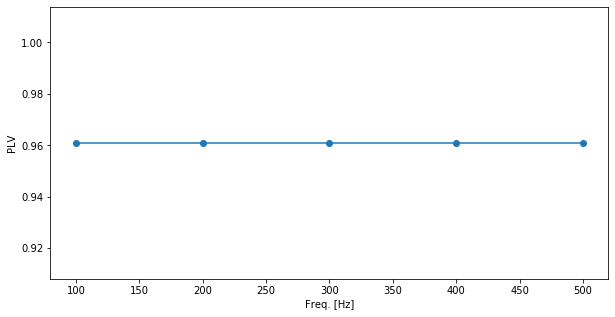

In [247]:
phase_corr_ = np.zeros((5,))
for idx, f_c in enumerate(np.arange(100,600,100)):
    # 1. gen signal
    x1 = simulate_osc_mor(f_c, noise)
    X = x1 + noise
                         
    x_filt = filter_data(X_down, f, 1000)
    phase_corr_[idx] = compute_phase_corr(x_filt, X1_down)
    
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(100,600,100), phase_corr_, '-o')
plt.ylabel('PLV')
plt.xlabel('Freq. [Hz]')

6. then lowpass filter and decimate the 5 kHz signal down to 1 kHz

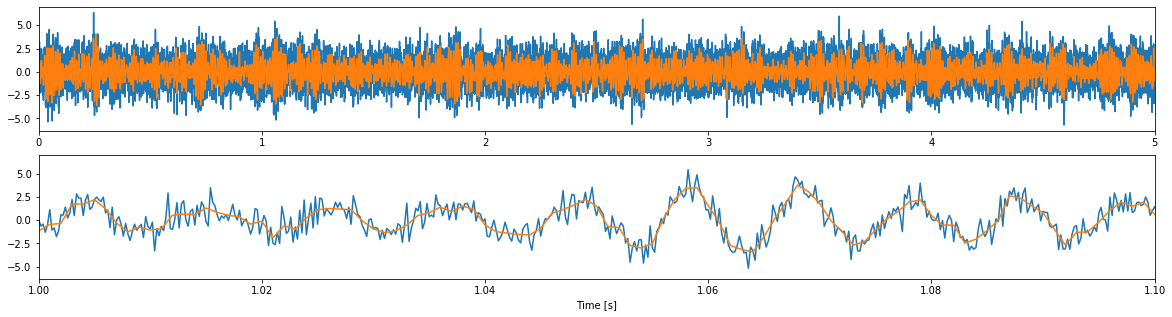

In [26]:
x1 = simulate_osc_mor(100, noise, 5000)
X = x1 + noise

x_c_down = signal.decimate(X, 5, ftype='fir')
t_down = np.arange(0,5,1/1000)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,5))
ax1.plot(t, np.real(X))
ax1.plot(t_down, np.real(x_c_down))
ax1.set_xlim([0,5])

ax2.plot(t, np.real(X))
ax2.plot(t_down, np.real(x_c_down))
ax2.set_xlim([1,1.1])
ax2.set_xlabel('Time [s]');
fig.savefig('/home/gabri/nyquist_panelc.svg', dpi=300)

7. reapply 3-5 to the 1kHz sampled signals and observe that up to 300 or 400 Hz, the signal amplitude and phase are estimated as well as for 5 kHz

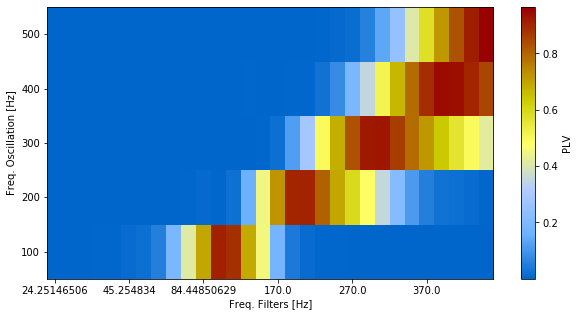

In [32]:
n_freqs_x = 30
frequencies = get_frequencies()

phase_corr_down = np.zeros((5,n_freqs_x))
for idx, f_c in enumerate(np.arange(100,600,100)):
    # 1. gen signal
    x1 = simulate_osc_mor(f_c, noise)
    X = x1 + noise
    
    X_down = signal.decimate(X, 5, ftype='fir')
    X1_down= signal.decimate(x1, 5, ftype='fir')

    for jdx, f in enumerate(frequencies[-n_freqs_x:]): 
        
        x_filt = filter_data(X_down, f, 1000)
        phase_corr_down[idx, jdx] = compute_phase_corr(x_filt, X1_down)
    
fig = plt.figure(figsize=(10,5))
plt.imshow(phase_corr_down, aspect='auto', cmap=ripples_cmap)
plt.gca().invert_yaxis()
plt.yticks(range(5),np.arange(100,600,100))
plt.xticks(range(0,n_freqs_x,5), frequencies[-n_freqs_x::5])
plt.ylabel('Freq. Oscillation [Hz]')
plt.xlabel('Freq. Filters [Hz]')
plt.colorbar().set_label('PLV')


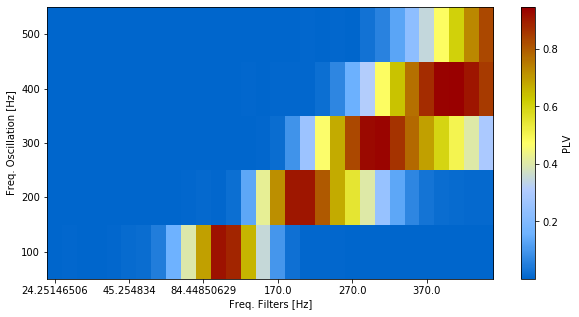

In [33]:
n_freqs_x = 30

phase_corr_up = np.zeros((5,n_freqs_x))
for idx, f_c in enumerate(np.arange(100,600,100)):
    # 1. gen signal
    x1 = simulate_osc_mor(f_c, noise, fs=5000)
    X = np.real(x1) + noise
    
    for jdx, f in enumerate(frequencies[-n_freqs_x:]): 
        x_filt = filter_data(X, f, 5000)
        phase_corr_up[idx, jdx] = compute_phase_corr(x1, x_filt)
    
fig = plt.figure(figsize=(10,5))
plt.imshow(phase_corr_up, aspect='auto', cmap=ripples_cmap)
plt.gca().invert_yaxis()
plt.yticks(range(5),np.arange(100,600,100))
plt.xticks(range(0,n_freqs_x,5), frequencies[-n_freqs_x::5])
plt.ylabel('Freq. Oscillation [Hz]')
plt.xlabel('Freq. Filters [Hz]')
plt.colorbar().set_label('PLV')

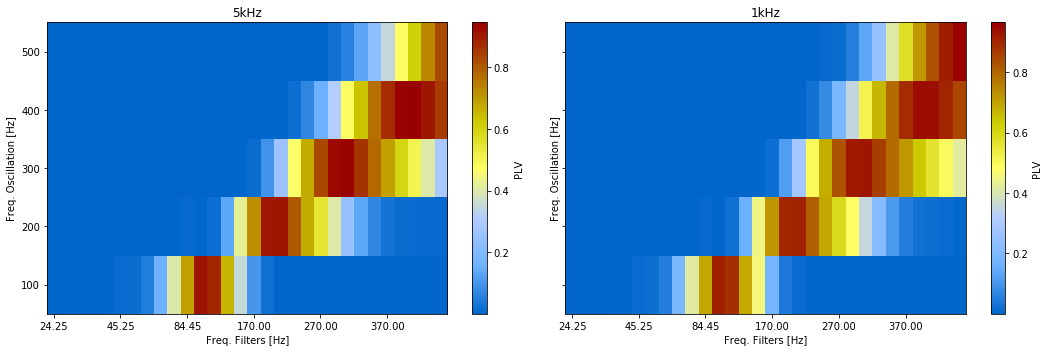

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(15,5))

im1 = ax1.imshow(phase_corr_up, aspect='auto', cmap=ripples_cmap)
ax1.invert_yaxis()
ax1.set_title('5kHz')
im2 = ax2.imshow(phase_corr_down, aspect='auto', cmap=ripples_cmap)
ax2.invert_yaxis()
ax2.set_title('1kHz')

x_labels = ["%.2f"%x for x in frequencies[-n_freqs_x::5]]

ax1.set_yticks(range(5))
ax1.set_yticklabels(np.arange(100,600,100))
ax1.set_xticks(range(0,n_freqs_x,5))
ax1.set_xticklabels(x_labels)
ax1.set_ylabel('Freq. Oscillation [Hz]')
ax1.set_xlabel('Freq. Filters [Hz]')

ax2.set_yticks(range(5))
ax2.set_yticklabels(np.arange(100,600,100))
ax2.set_xticks(range(0, n_freqs_x, 5))

ax2.set_xticklabels(x_labels)
ax2.set_ylabel('Freq. Oscillation [Hz]')
ax2.set_xlabel('Freq. Filters [Hz]')

plt.colorbar(im1, ax=ax1).set_label('PLV')
plt.colorbar(im2, ax=ax2).set_label('PLV')
fig.tight_layout()
fig.savefig('/home/gabri/nyquist_paneld.svg', dpi=300)

In [40]:
phase_corr_up.shape

(5, 30)

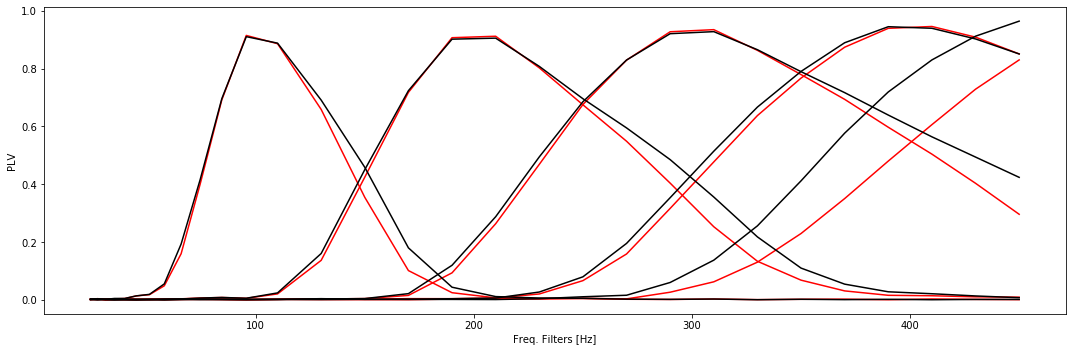

In [58]:
fig = plt.figure(figsize=(15,5))

plt.plot(frequencies[-n_freqs_x:], phase_corr_up.T, color='r', label='5kHz')
plt.plot(frequencies[-n_freqs_x:], phase_corr_down.T, color='k', label='1kHz')

plt.ylabel('PLV')
plt.xlabel('Freq. Filters [Hz]')


fig.tight_layout()
fig.savefig('/home/gabri/nyquist_paneld.svg', dpi=30)

In [62]:
x = np.random.rand(10)
y = np.fft.fft(x)
print(x,np.real(y))

[0.30723725 0.23810277 0.36574988 0.24251684 0.44588398 0.76526475
 0.2345431  0.56199944 0.6931346  0.72528559] [ 4.57971821 -0.15050292  0.07294602 -0.75125555  0.31844988 -0.48662058
  0.31844988 -0.75125555  0.07294602 -0.15050292]
